In [1]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import pandas as pd
from datetime import date
import matplotlib as mpl
from matplotlib import pyplot as plt

from utils.basic_utils import csv_store, csv_ext, numeric_cols, csv_load
from utils.pricing import dummy_col, px_fwd_ret, get_ind_index, discret_rets
from utils.pricing import rename_col
from utils.fundamental import chain_outlier
from utils.TechnicalDS import TechnicalDS
from utils.pred_utils import get_top_predictions, get_most_frequent_preds
from utils.pred_utils import get_study_date_range, stop_loss, plot_symbol_hist_pred

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

mpl.rcParams['figure.figsize'] = [5.0, 3.0]
mpl.rcParams['font.size'] = 8
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'large'

Loading utils/config.json


Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Context

In [3]:
active_model = 'ns'

model_dict = {
    '05-24-19': {
        'model': 'micro_TF-05-24-19.h5',
        'features': 'micro_TF_train_cols-05-24-19.npy',
        'local_pred': 'micro_pred-5-29-19-15-yrs.h5'
    },
    'bp': {
        'model': 'micro_TF-bp.h5',
        'features': 'micro_TF_train_cols-bp.npy',
        'local_pred': 'micro_pred-bp-15-yrs-bp.h5'
    },
    'all': {
        'model': 'micro_TF-all.h5',
        'features': 'micro_TF_train_cols-all.npy',
        'local_pred': 'micro_pred-all-15-yrs-all.h5'
    },
    'ns': {
        'model': 'micro_TF-ns.h5',
        'features': 'micro_TF_train_cols-ns.npy',
        'local_pred': 'micro_pred-all-15-yrs-ns.h5'
    }
}

# context
context = {
    'ml_path': '../ML/',
    'tmp_path': '../tmp/',    
    'px_vol_ds': 'universe-px-vol-ds.h5',    
    'model_name': f'{model_dict[active_model]["model"]}',
    'trained_cols': f'{model_dict[active_model]["features"]}',
    'look_ahead': 120,
    'smooth': 1,
    'look_back': 252*15,
    'load_ds': True,
    'scale': True,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
}

#### Load dataset

In [4]:
tech_ds = TechnicalDS(
    context['tmp_path'], 
    context['px_vol_ds'], 
    load_ds=True, 
    look_ahead=context['look_ahead'], 
#     fwd_smooth=context['smooth'], 
    max_draw_on=True, 
    tickers='All',
)
y_col = tech_ds.ycol_name

# tech_ds.create_base_frames()
# cut_range = tech_ds.return_intervals(tresholds=[0.4, 0.75])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4673 entries, 2004-07-14 to 2019-07-15
Columns: 6375 entries, (high, 0700.HK) to (volume, ^VIX)
dtypes: float32(6375)
memory usage: 113.7 MB
None
Target date: 2019-07-15
Loading file quote/csv/2019-07-15
Loading file summary-categories/defaultKeyStatistics/2019-07-15
Loading file summary-categories/financialData/2019-07-15
Loading file summary-categories/assetProfile
1198 companies
Universe sectors: 11, industries: 135


In [ ]:
tech_ds.stitch_companies_groups()

In [5]:
quotes = tech_ds.quotes
profile = tech_ds.profile
price_share = 20
min_volume_shares = 0.3e6
liquid_tickers = list(quotes.loc[
    (quotes.quoteType == 'EQUITY') &
    (quotes.regularMarketPrice > price_share) & 
    (quotes.averageDailyVolume3Month > min_volume_shares)
    , 'symbol'])
tech_ds.tickers = liquid_tickers
# quotes.loc[quotes.regularMarketPrice < 50, 'regularMarketPrice'].hist(bins=50)
# quotes.loc[quotes.v < 50, 'regularMarketPrice']
# quotes.loc[quotes.averageDailyVolume3Month > 0.3e6, 'averageDailyVolume3Month'].hist(bins=50)
labels_list = list(reversed(range(len(tech_ds.forward_return_labels))))

print(f'Liquid tickers: >${price_share} and >{min_volume_shares} shares/day: {len(liquid_tickers)}')
clean_px, labels = tech_ds.clean_px, tech_ds.forward_return_labels

Liquid tickers: >$20 and >300000.0 shares/day: 892


#### Predict

In [8]:
def pre_process_ds(context):
    raw_df = tech_ds.stitch_companies_groups()
    print(f'Shape excluding NAs: {raw_df.shape}')
    symbols = raw_df.reset_index().set_index(['symbol']).index
    sector_map = tech_ds.profile.loc[tech_ds.tickers,'sector'].to_dict()
    raw_df.loc[:, 'sector'] = symbols.map(sector_map)
    raw_df = chain_outlier(raw_df, None)
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(raw_df)
    if scale_on: raw_df.loc[:, num_cols] = scaler.fit_transform(
        raw_df[num_cols])
    # add categoricals
    raw_df.dropna(subset=['sector'], inplace=True)
    raw_df = dummy_col(raw_df, 'sector', shorten=True)
    return raw_df

In [9]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    joined_df.reset_index(level=1, inplace=True)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

    labels = tech_ds.forward_return_labels
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

#     # store in S3
#     s3_path = context['s3_path']
#     s3_df = pred_df.reset_index(drop=False)
#     rename_col(s3_df, 'index', 'pred_date')
#     csv_store(s3_df, s3_path, csv_ext.format(tech_ds.tgt_date))

    return pred_df

In [10]:
%%time 
# predict for all
pred_df = predict_ds(context)

Group index
Group percentage changes
Group pct stds
Group performance deltas
% above MA by group
% positive / negative chg stds by group
Group 50 day stds
Group 50 day deltas
Ranked returns dataframes
Dataset columns: Index(['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'IntraDayChg',
       'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA',
       'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'PctChgStds1',
       'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'MaxDraw120',
       'MaxPull120', 'PerfRank20', 'PerfRank50', 'PerfRank200', 'fwdRet120',
       '50StdsAll', '50StdsSect', '50StdsInd', '200StdsAll', '200StdsSect',
       '200StdsInd', 'pctGt50MAAll', 'pctGt50MASect', 'pctGt50MAInd',
       'pctGt200MAAll', 'pctGt200MASect', 'pctGt200MAInd', 'pctPosStdsAll',
       'pctPosStdsSect', 'pctPosStdsInd', 'pctNegStdsAll', 'pctNegStdsSect',
       'pctNegStdsInd', 'PerfRank20All', 'PerfRank20Sect', 'PerfRank20Ind',
       'PerfRank50All', 'PerfRank5

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


pred_X.shape (3303125, 70)
pred_X.shape (3303125, 69)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loaded ../ML/micro_TF-ns.h5
CPU times: user 1h 58min 43s, sys: 1h 26min 7s, total: 3h 24min 50s
Wall time: 21min 45s


#### Long-Term Experiment Predictions

In [13]:
lt_exp_fname = f'{model_dict[active_model]["local_pred"]}'
lt_exp_fname

'micro_pred-all-15-yrs-ns.h5'

In [19]:
# CAREFUL, IT OVERRIDES LOCAL FILE
# pred_df.to_hdf(tmp_path + lt_exp_fname, key='micro_pred')

In [20]:
pred_df = pd.read_hdf(tmp_path + lt_exp_fname)
pred_df = pred_df.loc[
    pred_df.symbol.isin(liquid_tickers) &
    pred_df.confidence > min_confidence
]
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2630637 entries, 2005-06-16 to 2019-06-17
Data columns (total 10 columns):
symbol        object
pred_class    int64
pred_label    object
confidence    float64
bear          float32
short         float32
negative      float32
positive      float32
long          float32
bull          float32
dtypes: float32(6), float64(1), int64(1), object(2)
memory usage: 160.6+ MB


#### Today's predictions

In [41]:
%%time
# read from S3
from utils.basic_utils import csv_load
s3_path = context['s3_path']
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tech_ds.tgt_date}'), 
#     csv_load(f'{s3_path}2019-06-19'),     
    index_col='pred_date', parse_dates=True)
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105120 entries, 2018-12-28 to 2019-06-20
Data columns (total 10 columns):
symbol        105120 non-null object
pred_class    105120 non-null int64
pred_label    105120 non-null object
confidence    103574 non-null float64
bear          103574 non-null float64
short         103574 non-null float64
negative      103574 non-null float64
positive      103574 non-null float64
long          103574 non-null float64
bull          103574 non-null float64
dtypes: float64(7), int64(1), object(2)
memory usage: 8.8+ MB
CPU times: user 240 ms, sys: 78.3 ms, total: 319 ms
Wall time: 2.99 s


In [36]:
pred_df.tail()

,symbol,pred_class,pred_label,confidence,bear,short,negative,positive,long,bull
pred_date,,,,,,,,,,
2019-06-20,ZBH,1,short,0.333,0.167,0.333,0.259,0.189,0.050,0.002
2019-06-20,ZBRA,0,bear,0.858,0.858,0.030,0.017,0.026,0.031,0.038
2019-06-20,ZEN,0,bear,nan,nan,nan,nan,nan,nan,nan
2019-06-20,ZION,5,bull,0.803,0.003,0.029,0.032,0.054,0.079,0.803
2019-06-20,ZTS,0,bear,0.689,0.689,0.140,0.049,0.064,0.031,0.026


In [43]:
# 'QQQ' in tech_ds.tickers
# pred_df.loc[pred_df.symbol.isin(tech_ds.sectors)]
pred_df.loc[pred_df.symbol.isin(['AMZN'])]
# pred_df.symbol.unique()
# quotes.loc['XLK']

,symbol,pred_class,pred_label,confidence,bear,short,negative,positive,long,bull
pred_date,,,,,,,,,,
2018-12-28,AMZN,5,bull,0.457,0.252,0.083,0.051,0.072,0.084,0.457
2018-12-31,AMZN,5,bull,0.605,0.086,0.080,0.057,0.074,0.097,0.605
2019-01-02,AMZN,0,bear,0.689,0.689,0.127,0.042,0.036,0.025,0.081
2019-01-03,AMZN,5,bull,0.458,0.305,0.097,0.046,0.045,0.049,0.458
2019-01-04,AMZN,0,bear,0.892,0.892,0.074,0.013,0.006,0.003,0.012
2019-01-07,AMZN,0,bear,0.864,0.864,0.105,0.018,0.007,0.002,0.003
2019-01-08,AMZN,0,bear,0.945,0.945,0.046,0.005,0.002,0.001,0.000
2019-01-09,AMZN,0,bear,0.627,0.627,0.205,0.067,0.056,0.030,0.016
2019-01-10,AMZN,0,bear,0.850,0.850,0.109,0.021,0.012,0.004,0.002


### Visualize one company

In [14]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


bear       0.421
bull       0.370
long       0.062
short      0.060
positive   0.057
negative   0.031
Name: pred_label, dtype: float64

In [15]:
# symbol = np.random.choice(tech_ds.tickers)
symbol = 'RH'
print(f'Active symbol: {symbol}')

Active symbol: RH


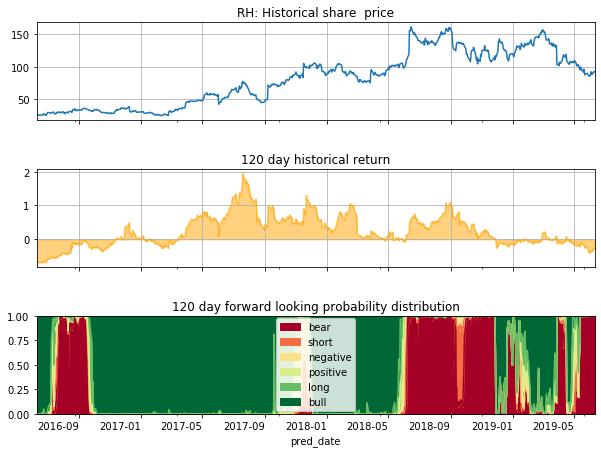

In [20]:
from utils.pred_utils import plot_symbol_hist_pred
plot_symbol_hist_pred(symbol, clean_px, 252*3, context, pred_df, labels)

plt.savefig(f'../images/{symbol}-pred-chart.png', 
            bbox_inches='tight',
            dpi=200)

In [60]:
pred_df.loc[pred_df.symbol.isin([symbol])].tail(10)

,symbol,pred_class,pred_label,confidence,bear,short,negative,positive,long,bull
pred_date,,,,,,,,,,
2019-05-29,SHW,5,bull,0.434,0.313,0.097,0.020,0.014,0.122,0.434
2019-05-30,SHW,0,bear,0.850,0.850,0.090,0.009,0.004,0.015,0.033
2019-05-31,SHW,0,bear,0.753,0.753,0.104,0.016,0.012,0.029,0.086
2019-06-03,SHW,0,bear,0.783,0.783,0.037,0.019,0.018,0.051,0.093
2019-06-04,SHW,0,bear,0.830,0.830,0.097,0.070,0.003,0.000,0.000
2019-06-05,SHW,0,bear,0.979,0.979,0.007,0.008,0.003,0.002,0.000
2019-06-06,SHW,0,bear,0.916,0.916,0.051,0.017,0.008,0.004,0.003
2019-06-07,SHW,0,bear,0.481,0.481,0.072,0.072,0.188,0.065,0.120
2019-06-10,SHW,0,bear,0.332,0.332,0.044,0.089,0.217,0.132,0.187


### Assumptions

In [115]:
# Key inputs
long = False # enable long or short
loss_protection = False # stop losses dont seem to help
max_loss = 0.1
holding_period = 120 # how many days to hold / rebalance
as_of_date = -holding_period
as_of_date = -1
watch_overtime = True # pick most frequent predictions within X study period
study_period = -20;
min_confidence = 0.8 # cut off
period_tresh = 0.7 # percent of time in the list during study period
nbr_positions = 50
pred_classes = labels_list[:2] if long else labels_list[-2:]
# pred_classes = [0, 1, 2, 3, 4] # all classes, is it a good picker?

ls_categ = "long" if long else "short"
dd_folder = './dd/'
os.makedirs(dd_folder, exist_ok=True)

look_ahead = context['look_ahead']
look_back = context['look_back']
tmp_path = context['tmp_path']

### AI portfolio -- one period

In [105]:
# pred_df.loc[pred_df.pred_class.isin(pred_classes)].sort_values(by='confidence', ascending=False)

In [106]:
top_pred = get_top_predictions(pred_df, as_of_date, pred_classes, min_confidence)

In [107]:
study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

DatetimeIndex(['2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31', '2019-06-03', '2019-06-04',
               '2019-06-05', '2019-06-06', '2019-06-07', '2019-06-10',
               '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14',
               '2019-06-17'],
              dtype='datetime64[ns]', name='pred_date', freq=None)

In [108]:
most_freq_df = get_most_frequent_preds(
    pred_df, study_dates, top_pred, 
    pred_classes, period_tresh)

if watch_overtime: top_pos = most_freq_df.head(nbr_positions)
else: top_pos = top_pred.loc[
        top_pred.pred_class.isin(pred_classes) & 
        top_pred.confidence > min_confidence].head(nbr_positions)

symbols = list(top_pos.symbol)
print(f'{len(symbols)} {"LONG" if long else "SHORT"} Symbols, {symbols}')
# top_pred.loc[top_pred.symbol.isin(symbols)]

50 LONG Symbols, ['MS', 'EDU', 'LW', 'MIME', 'LGND', 'RAMP', 'TTD', 'AIZ', 'TSLA', 'COF', 'ALRM', 'IDXX', 'ILMN', 'SQ', 'JLL', 'MYGN', 'PBF', 'WY', 'LIVN', 'BIDU', 'DATA', 'STL', 'SEIC', 'BLK', 'PXD', 'SBNY', 'PYPL', 'SCHW', 'ETFC', 'BXS', 'BL', 'FTV', 'HWC', 'WST', 'INGN', 'STI', 'CMA', 'NOAH', 'WAT', 'WBS', 'PNFP', 'PRAH', 'NKE', 'FIVN', 'BLUE', 'NRG', 'V', 'GWPH', 'SFTBY', 'DFS']


#### Share allocation

In [ ]:
amount = 800000/6

show_cols = ['shortName', 'regularMarketPrice', 'averageDailyVolume3Month', 'marketCap']
quote_alloc = quotes.loc[symbols, show_cols]
show_cols = ['sector', 'industry']
profile_alloc = profile.loc[symbols, show_cols]

allocation = amount * (1 if long else -1) / len(symbols)
alloc_df = (allocation / quotes.loc[symbols, ['regularMarketPrice']]).round(0)
# alloc_df.columns = ['shares']
alloc_df['dollarValue'] = alloc_df * quotes.loc[symbols, ['regularMarketPrice']]
alloc_df.columns = ['shares', 'dollarValue']
alloc_df = pd.concat([alloc_df, quote_alloc, profile_alloc], axis=1)
alloc_df.to_csv(f'{"long" if long else "short"}-{str(date.today())}.csv')
alloc_df

In [ ]:
# index for predictions
get_ind_index(clean_px[symbols], tail=252, name='^PORT')['^PORT'].plot(
    title='Historical Performance of Portfolio'
);

#### Descriptive stats

In [ ]:
# Distribution by sector
by_sect = tech_ds.profile.loc[symbols].groupby(by=['sector']).count().iloc[:,0].sort_values()
(by_sect / by_sect.sum()).plot.barh(title='Distribution by sector');

In [ ]:
# Distribution by industry
by_ind = tech_ds.profile.loc[symbols].groupby(by=['sector', 'industry']).count().iloc[:,0]
by_ind

In [ ]:
# Most consistent predictions
if watch_overtime:
    port_selection = top_pos.sort_values(
        by=[('confidence', 'count'), ('confidence', 'mean')], 
        ascending=False)
else: port_selection = top_pos

In [ ]:
# loss protection if enabled
idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {tech_ds.clean_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')
port_index.plot(
    title=f'{nbr_positions} Positions Performance over {holding_period} days', 
    alpha=0.5,
    legend=False);

In [ ]:
net_return = (port_index.iloc[-1, :-1] - 1)
hit_mask = net_return>0 if long else net_return<0
hit_rate = net_return.where(hit_mask).count() / net_return.count()
print(f'Hit Rate: {round(hit_rate*100, 1)}%')
net_return.sort_values().plot.bar(title='Cumulative Return', grid=True); plt.show()
net_return.plot.hist(bins=40, grid=True);

In [ ]:
# cumulative returns for a given portfolio
max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)

port_index.iloc[:, -1].plot(
    title=f'PORT {holding_period} day, MaxDraw: {max_d}, MaxPull: {max_p}');

In [ ]:
# cumulative returns for a given portfolio
port_index.iloc[-1, :-1].describe()

In [ ]:
print(port_index.shape)
port_index.tail()

### AI portfolios -- multiple periods

In [116]:
nbr_experiments = 500
describe_list = []; symbol_list = []; port_beg = []; port_end = []; pos_ret = []
profile, quotes = tech_ds.profile, tech_ds.quotes

In [27]:
# if running both long and short do nor re-run the indices to keep the same periods
mean_ret = pd.DataFrame()
pred_period_range = range(-study_period, pred_df.index.unique().shape[0] - holding_period)
start = np.random.choice(pred_period_range, size=1)
asofs_idx = np.unique([x for x in np.random.choice(pred_period_range, size=nbr_experiments)]) #random
# asofs_idx = [x for x in pred_period_range[:nbr_experiments]] # sequential
print(f'{len(asofs_idx)} Experiments')

462 Experiments


In [117]:
%%time

# What are the best portfolios and how do they perform?
for i, as_of_date in enumerate(asofs_idx):

    top_pred = get_top_predictions(pred_df, as_of_date, pred_classes, min_confidence)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    idx = tech_ds.clean_px.index.get_loc(study_dates[-1])

    if watch_overtime:    
        most_freq_df = get_most_frequent_preds(
            pred_df, study_dates, top_pred, pred_classes, period_tresh)
        top_pos = most_freq_df.head(nbr_positions)
    else:
        top_pos = top_pred.loc[
            top_pred.pred_class.isin(pred_classes) & 
            top_pred.confidence > min_confidence]\
            .head(nbr_positions)
    
    symbols = list(top_pos.symbol)

    if len(symbols) > 5:
        prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        net_return = (port_index.iloc[-1, :-1] - 1)
        hit_mask = net_return>0 if long else net_return<0
        hit_rate = net_return.where(hit_mask).count() / net_return.count()
        
        pos_beg = port_index.iloc[0, :-1]
        pos_end = port_index.iloc[-1, :-1]
        max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
        max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)
        
        exp_describe = port_index.iloc[:, -1].describe()
        exp_describe['max_draw'] = max_d
        exp_describe['max_pull'] = max_p
        exp_describe['hit_rate'] = hit_rate                
        exp_describe['predicted_on'] = str(study_dates[-1])
        exp_describe['measured_on'] = str(port_index.index[-1])
        exp_describe['offset_start'] = as_of_date
        exp_describe['study_period'] = study_period
        
        port_beg.append(pos_beg)
        port_end.append(pos_end)
        pos_ret.append(net_return)
        symbol_list.append(symbols)
        describe_list.append(exp_describe)
    print(f'#{i+1}, {study_dates[-1].strftime("%Y-%m-%d")}')
    
portfolio_sel = pd.concat(port_beg, axis=1, sort=False).T
position_perf = pd.concat(port_end, axis=1, sort=False).T
hist_ports = pd.concat(describe_list, axis=1, sort=False).T
hist_ports = hist_ports.infer_objects()
hist_ports.index = pd.to_datetime(hist_ports.predicted_on)
          
sub1_cols = ['mean','min','25%','50%','75%', 'max']
hist_ports[sub1_cols] = hist_ports[sub1_cols] - 1
hist_ports['sharpe'] = np.abs(hist_ports['mean']) / hist_ports['std']
col_order = [
    'count','mean','std','sharpe','max_draw','max_pull','hit_rate',
    'min','25%','50%','75%','max',
    'predicted_on','measured_on','offset_start','study_period']
hist_ports = hist_ports[col_order]

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


#1, 2005-07-18
#2, 2005-07-28
#3, 2005-07-29
#4, 2005-08-08
#5, 2005-08-11
#6, 2005-08-18
#7, 2005-08-22
#8, 2005-08-26
#9, 2005-09-01
#10, 2005-09-14
#11, 2005-09-27
#12, 2005-09-28
#13, 2005-10-25
#14, 2005-11-02
#15, 2005-11-04
#16, 2005-11-11
#17, 2005-11-23
#18, 2005-12-14
#19, 2005-12-29
#20, 2006-01-04
#21, 2006-01-10
#22, 2006-01-11
#23, 2006-01-25
#24, 2006-02-02
#25, 2006-02-13
#26, 2006-03-07
#27, 2006-03-08
#28, 2006-03-20
#29, 2006-03-28
#30, 2006-04-04
#31, 2006-06-12
#32, 2006-06-16
#33, 2006-06-27
#34, 2006-06-28
#35, 2006-07-21
#36, 2006-07-24
#37, 2006-08-01
#38, 2006-08-03
#39, 2006-08-17
#40, 2006-08-25
#41, 2006-08-31
#42, 2006-09-07
#43, 2006-09-18
#44, 2006-09-20
#45, 2006-10-02
#46, 2006-10-05
#47, 2006-10-23
#48, 2006-10-24
#49, 2006-11-06
#50, 2006-11-09
#51, 2006-11-21
#52, 2006-11-24
#53, 2006-11-27
#54, 2006-12-05
#55, 2006-12-14
#56, 2006-12-20
#57, 2006-12-22
#58, 2007-01-09
#59, 2007-01-24
#60, 2007-02-02
#61, 2007-02-07
#62, 2007-02-09
#63, 2007-02-16
#

In [118]:
print(f'Summary for {len(asofs_idx)} unique {"LONG" if long else "SHORT"} experiments')
print(f'{len(position_perf.columns.unique())} unique symbols (from different portfolios)')

Summary for 462 unique SHORT experiments
798 unique symbols (from different portfolios)


In [119]:
show_cols = [
    'mean','std','sharpe','max_draw','max_pull',
    'min','25%','50%','75%','max','hit_rate', 
    'predicted_on','measured_on']

# mean	sharpe	max_draw	max_pull	min	25%	50%	75%	max	std	hit_rate

# full backtest details
df = hist_ports[show_cols]
fname = f'{dd_folder}{ls_categ}-detail.csv'
df.to_csv(fname)

# summary of risk metrics
df = hist_ports[show_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
fname = f'{dd_folder}{ls_categ}-summary-metrics.csv'
df.to_csv(fname)

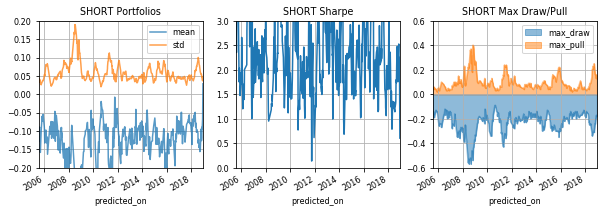

In [120]:
# trend
show_cols = ['mean', 'std', 'sharpe', 'max_draw', 'max_pull']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=False)

hist_ports[['mean', 'std']].plot.line(
    grid=True, ylim=(-0.2,0.2), alpha=0.75,
    title=f'{str.upper(ls_categ)} Portfolios', 
    ax=axes[0]);
hist_ports['sharpe'].plot.line(
    grid=True, ylim=(0,3),
    title=f'{str.upper(ls_categ)} Sharpe', ax=axes[1]);
hist_ports[['max_draw', 'max_pull']].plot.area(
    grid=True, ylim=(-0.6,0.6), alpha=0.5, stacked=False,
    title=f'{str.upper(ls_categ)} Max Draw/Pull', ax=axes[2]);

plt.savefig(f'./dd/{ls_categ}-trend.png', 
            bbox_inches='tight',
            dpi=200)

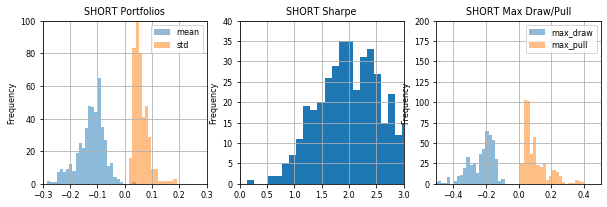

In [121]:
# histograms

# mean/std -> xlim=(-0.5,1)
# sharpe -> xlim=(0,3)
# Max draw/pull -> xlim=(-0.5,1)

# mean/std -> ylim=(0,100)
# sharpe -> ylim=(0,40)
# Max draw/pull -> ylim=(0,200)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=False)
plt.subplots_adjust(hspace=.5)
# hist_ports.hist(column=show_cols, bins=50, layout=(1,len(show_cols)), ax=axes);
hist_ports[['mean', 'std']].plot.hist(
    bins=50, alpha=0.5, grid=True, 
    xlim=(-0.3, 0.3), ylim=(0,100),
    title=f'{str.upper(ls_categ)} Portfolios', 
    ax=axes[0]);
hist_ports['sharpe'].plot.hist(
    bins=50, grid=True, 
    xlim=(0, 3), ylim=(0,40),
    title=f'{str.upper(ls_categ)} Sharpe', ax=axes[1]);
hist_ports[['max_draw', 'max_pull']].plot.hist(
    bins=50, alpha=0.5, grid=True, 
    xlim=(-0.5, 0.5), ylim=(0,200),
    title=f'{str.upper(ls_categ)} Max Draw/Pull', ax=axes[2]);

plt.savefig(f'./dd/{ls_categ}-histogram.png', 
            bbox_inches='tight',
            dpi=200)

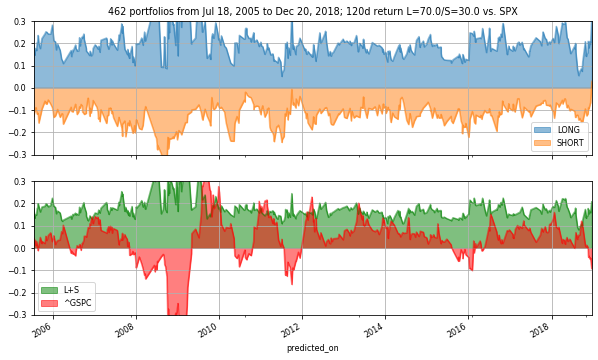

In [122]:
# historical performance chart
l_w = 0.7
bench = '^GSPC'

if long: mean_ret['LONG'] = hist_ports['mean'].copy()
elif not long: mean_ret['SHORT'] = hist_ports['mean'].copy()

if 'LONG' in mean_ret.columns and 'SHORT' in mean_ret.columns:
    mean_ret['L+S'] = (mean_ret['LONG']) * l_w - (mean_ret['SHORT']) * (1-l_w)
    from_dt, to_dt = list(mean_ret.index[[0,-1]])
    from_dt = from_dt.strftime('%b %d, %Y')
    to_dt = to_dt.strftime('%b %d, %Y')
    
    SPX_df = clean_px['^GSPC']
    SPX_df = SPX_df.pct_change(look_ahead).to_frame()
    mean_ret[bench] = SPX_df.loc[mean_ret.index.unique()]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)
    
    ax = mean_ret[['LONG', 'SHORT']].plot.area(
        title=f'{mean_ret.shape[0]} portfolios from {from_dt} to {to_dt}; {holding_period}d return L={l_w*100}/S={round(1-l_w, 1)*100} vs. SPX',
        stacked=False, ylim=(-.3, .3), grid=True, ax=axes[0]
    )
    
    mean_ret[['L+S', bench]].plot.area(
        stacked=False, ylim=(-.3, .3), grid=True,
        color=['green', 'red'],
        ax=axes[1]
    )
    
    plt.savefig(f'{dd_folder}backtest.png', 
                bbox_inches='tight',
                dpi=200);

In [123]:
# portfolio return statistics
df = mean_ret.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
fname = f'{dd_folder}perf-table.csv'
df.to_csv(fname)
df

,LONG,SHORT,L+S,^GSPC
count,462.000,462.000,462.000,462.000
mean,0.195,-0.127,0.174,0.033
std,0.065,0.056,0.047,0.111
min,0.051,-0.387,0.082,-0.390
1%,0.074,-0.333,0.096,-0.351
25%,0.157,-0.152,0.148,-0.007
50%,0.188,-0.117,0.165,0.048
75%,0.220,-0.091,0.186,0.092
99%,0.459,-0.029,0.387,0.266
max,0.531,0.029,0.419,0.357


In [124]:
from datetime import date, timedelta
show_cols = ['net_exp', bench]
if 'net_exp' in mean_ret.columns:
    df = mean_ret[show_cols].copy()
    df.index = pd.to_datetime(df.index.date - timedelta(holding_period))
    df['year'] = df.index.year
    df['month'] = df.index.month
    group_ret_df = df.groupby(by=['year', 'month']).mean()
    group_ret_df.plot(
        title=f'Inception Returns vs. SP500 ({len(mean_ret.index)} Iterations)',
        figsize=(10,5),
        grid=True);
    plt.savefig(f'{dd_folder}net-exposure.png', dpi=300)

#### Descriptive stats

In [125]:
perf_col = f'{holding_period}DReturn'
pos_attribution = position_perf.mean()
uniq_pos_perf = pos_attribution.to_frame()
uniq_pos_perf.columns = [perf_col]
uniq_pos_perf['name'] = quotes.loc[uniq_pos_perf.index, ['shortName']]
uniq_pos_perf[['sector', 'industry']] = profile.reindex(index=uniq_pos_perf.index, columns=['sector', 'industry'])

In [126]:
# top ten attribution
# top10_attrib = uniq_pos_perf.sort_values(by=perf_col, ascending=False).head()
# top10_attrib

In [127]:
# bottom ten attribution
# uniq_pos_perf.sort_values(by=perf_col, ascending=False).tail()

In [128]:
perf_sector = uniq_pos_perf.groupby(by=['sector']).agg(['mean', 'count'])
perf_ind = uniq_pos_perf.groupby(by=['industry']).mean().sort_values(by=perf_col) - 1

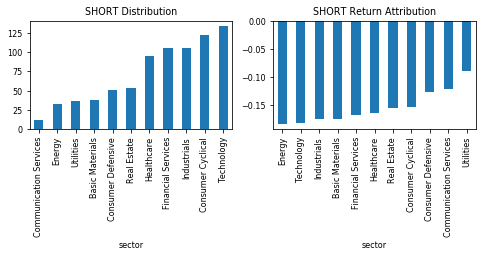

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
perf_sector[(perf_col, 'count')].sort_values().plot.bar(
    title=f'{str.upper(ls_categ)} Distribution', ax=axes[0]);
(perf_sector[(perf_col, 'mean')].sort_values() - 1).plot.bar(
    title=f'{str.upper(ls_categ)} Return Attribution', ax=axes[1]);

plt.savefig(f'{dd_folder}{ls_categ}-sector-attrib.png', 
            bbox_inches='tight',
            dpi=200)

In [130]:
# Distribution by industry
by_ind = uniq_pos_perf.groupby(by=['sector', 'industry']).count().iloc[:,0].sort_values(ascending=False)
by_ind.head(20)

df = by_ind.head(20).to_frame()
fname = f'{dd_folder}{ls_categ}-mean_return_ind.csv'
df.to_csv(fname)

In [131]:
# fsize = (5, len(perf_ind.index) / 25 * 5)
# perf_ind.plot.barh(title=f'{str.upper(ls_categ)} Return Attribution by Industry', figsize=fsize);
# plt.savefig(f'./dd/{ls_categ}-ind-attrib.png', 
#             bbox_inches='tight',            
#             dpi=200)

In [132]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

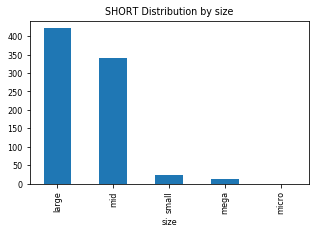

In [133]:
unique_symbols = list(uniq_pos_perf.index.unique())
size_df = tech_ds.quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.bar(
    title=f'{str.upper(ls_categ)} Distribution by size');

plt.savefig(f'./dd/{ls_categ}-by-size.png', 
            bbox_inches='tight',            
            dpi=200)

#### Most frequent

In [134]:
# Most common recommendations with realized performance
most_frequent = position_perf.count(axis=0).sort_values(ascending=False).head(50)
plot_df = most_frequent

# lens = len(plot_df.index); cols=4; rows=lens//cols+1
# fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 15), sharex=True)
# plt.subplots_adjust(wspace=0.3, hspace=0.3)

# for i, t in enumerate(zip(most_frequent.index, most_frequent.values)):
#     row = i // cols; col = i - cols * row
#     avg_return = round((pos_attribution[t[0]]-1) * 100, 1)
#     clean_px[t[0]].loc[position_perf.index].plot(
#         title=f'{t[0]}, {t[1]}, {avg_return}%',
#         ax=axes[row, col])
    
# plt.savefig(f'./dd/{ls_categ}-most-frequent.png', 
#             bbox_inches='tight',             
#             dpi=200)

### Dispersion stats

#### save dispersion

In [135]:
from utils.pred_utils import get_dispersion_stats

In [136]:
summ_feats_dict = {
    'pct_chg_df_dict[20]': tech_ds.pct_chg_df_dict[20],
    'pct_chg_df_dict[50]': tech_ds.pct_chg_df_dict[50],
    'pct_chg_df_dict[200]': tech_ds.pct_chg_df_dict[200],
    'pct_stds_df_dict[20]': tech_ds.pct_stds_df_dict[20].where(np.abs(tech_ds.pct_stds_df_dict[20])>0),
    'pct_stds_df_dict[50]': tech_ds.pct_stds_df_dict[50].where(np.abs(tech_ds.pct_stds_df_dict[50])>0),
    'pct_stds_df_dict[200]': tech_ds.pct_stds_df_dict[200].where(np.abs(tech_ds.pct_stds_df_dict[200])>0),    
    'hist_perf_ranks[20]': tech_ds.hist_perf_ranks[20],
    'hist_perf_ranks[50]': tech_ds.hist_perf_ranks[50],
    'hist_perf_ranks[200]': tech_ds.hist_perf_ranks[200],
    'max_draw_df': tech_ds.max_draw_df,
    'max_pull_df': tech_ds.max_pull_df,
    'pct_50d_ma_df': tech_ds.pct_50d_ma_df,
    'pct_200d_ma_df': tech_ds.pct_200d_ma_df,
    'pct_52wh_df': tech_ds.pct_52wh_df,
    'pct_52wl_df': tech_ds.pct_52wl_df,
    'pct_dv_10da_df': tech_ds.pct_dv_10da_df,
    'pct_dv_50da_df': tech_ds.pct_dv_50da_df,
    'dollar_value_df': tech_ds.dollar_value_df,
}

In [137]:
# save down dispersion stats for best longs and shorts
s_l = []
symbols = list(most_frequent.index)
sel_df = portfolio_sel[symbols]
for k in summ_feats_dict.keys():
    res_df = get_dispersion_stats(k, summ_feats_dict, sel_df, symbols)
    s_l.append(res_df)
disp_df = pd.concat(s_l, axis=1).T
disp_df.to_csv(f'./dd/equity_dispersion_{ls_categ}.csv')
disp_df['50%']

pct_chg_df_dict[20]             -0.007
pct_chg_df_dict[50]              0.003
pct_chg_df_dict[200]             0.017
pct_stds_df_dict[20]            -1.000
pct_stds_df_dict[50]             0.500
pct_stds_df_dict[200]            1.000
hist_perf_ranks[20]              0.431
hist_perf_ranks[50]              0.461
hist_perf_ranks[200]             0.445
max_draw_df                     -0.175
max_pull_df                      0.239
pct_50d_ma_df                    0.997
pct_200d_ma_df                   1.008
pct_52wh_df                      0.856
pct_52wl_df                      1.224
pct_dv_10da_df                   0.935
pct_dv_50da_df                   0.893
dollar_value_df         99,515,492.000
Name: 50%, dtype: float64

In [138]:
disp_df = pd.read_csv(f'./dd/equity_dispersion_{ls_categ}.csv', index_col=[0])

In [96]:
pd.read_csv(csv_load(f'models/equity_dispersion_{ls_categ}'), index_col=[0])

,25%,50%,75%
pct_chg_df_dict[20],0.026,0.037,0.047
pct_chg_df_dict[50],0.059,0.080,0.103
pct_chg_df_dict[200],0.188,0.275,0.363
pct_stds_df_dict[20],1.000,1.000,1.000
pct_stds_df_dict[50],1.000,1.000,1.000
pct_stds_df_dict[200],1.000,1.000,1.000
hist_perf_ranks[20],0.523,0.571,0.619
hist_perf_ranks[50],0.525,0.563,0.629
hist_perf_ranks[200],0.491,0.581,0.668
max_draw_df,-0.208,-0.170,-0.146


#### analyze dispersion

In [97]:
# create dispersion stats for a given universe, to compare against ideal metrics
s_l = []
for k in summ_feats_dict.keys():
    df = summ_feats_dict[k].loc[:, symbols].iloc[-1]
    df.name = k
    s_l.append(df)
latest_df = pd.concat(s_l, axis=1).T
latest_df.columns

Index(['MNST', 'NFLX', 'ILMN', 'MU', 'MA', 'HMSY', 'ISRG', 'HFC', 'DECK',
       'FNSR', 'CMG', 'STLD', 'DPZ', 'MYGN', 'AMZN', 'BKNG', 'RGEN', 'AMD',
       'DLTR', 'CF', 'JLL', 'ULTA', 'NVDA', 'CALM', 'MKTX', 'ATGE', 'IONS',
       'GEO', 'AAL', 'DXCM', 'AAPL', 'EW', 'CBRE', 'RIO', 'TAL', 'SBAC', 'FTI',
       'RS', 'TREX', 'SKX', 'WCG', 'CAR', 'NUS', 'LULU', 'INCY', 'BIDU',
       'SAFM', 'ORLY', 'CTRP', 'EXP'],
      dtype='object', name='symbol')

In [98]:
latest_df.T.describe().T

,count,mean,std,min,25%,50%,75%,max
pct_chg_df_dict[20],50.000,0.045,0.074,-0.090,-0.014,0.042,0.092,0.297
pct_chg_df_dict[50],50.000,0.003,0.149,-0.362,-0.056,0.005,0.067,0.444
pct_chg_df_dict[200],50.000,0.042,0.289,-0.510,-0.095,-0.003,0.237,0.744
pct_stds_df_dict[20],9.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
pct_stds_df_dict[50],7.000,0.714,1.380,-1.000,0.000,1.000,1.000,3.000
pct_stds_df_dict[200],7.000,1.143,1.069,-1.000,1.000,1.000,2.000,2.000
hist_perf_ranks[20],50.000,0.583,0.222,0.130,0.378,0.601,0.748,0.963
hist_perf_ranks[50],50.000,0.420,0.244,0.023,0.272,0.381,0.553,1.000
hist_perf_ranks[200],50.000,0.380,0.242,0.014,0.171,0.342,0.582,0.938
max_draw_df,50.000,-0.185,0.084,-0.417,-0.246,-0.157,-0.129,-0.043


In [99]:
disp_df['50%']

pct_chg_df_dict[20]              0.039
pct_chg_df_dict[50]              0.068
pct_chg_df_dict[200]             0.216
pct_stds_df_dict[20]             1.000
pct_stds_df_dict[50]             1.000
pct_stds_df_dict[200]            1.000
hist_perf_ranks[20]              0.577
hist_perf_ranks[50]              0.555
hist_perf_ranks[200]             0.530
max_draw_df                     -0.186
max_pull_df                      0.357
pct_50d_ma_df                    1.037
pct_200d_ma_df                   1.115
pct_52wh_df                      0.909
pct_52wl_df                      1.505
pct_dv_10da_df                   0.920
pct_dv_50da_df                   0.859
dollar_value_df         43,100,632.000
Name: 50%, dtype: float64

In [100]:
# latest_df[symbols[-3]]
# latest_df['TSLA']

In [101]:
ratio_disp_df = latest_df.T.div(disp_df['50%']).T
ranked_df = ratio_disp_df.rank(axis=1, method='dense', pct=True)
ranked_df = ranked_df.mean().sort_values(ascending=True if long else False)
ranked_df = ranked_df.tail(int(len(ranked_df) * .8))
ranked_df

symbol
FTI    0.409
FNSR   0.410
IONS   0.421
EXP    0.421
ISRG   0.422
CTRP   0.423
AAL    0.436
SAFM   0.449
MNST   0.458
CBRE   0.463
BKNG   0.466
RS     0.476
JLL    0.477
TREX   0.479
AAPL   0.479
HMSY   0.512
AMZN   0.513
ORLY   0.519
WCG    0.520
SKX    0.529
NFLX   0.534
INCY   0.544
CF     0.545
RIO    0.557
ULTA   0.604
GEO    0.613
TAL    0.617
CAR    0.631
CMG    0.657
MA     0.663
ILMN   0.671
DLTR   0.686
LULU   0.689
AMD    0.748
EW     0.751
DECK   0.760
DXCM   0.767
SBAC   0.782
MKTX   0.845
RGEN   0.896
dtype: float64

In [112]:
# get_ind_index(clean_px[ranked_df.index[:10]], tail=20)
get_ind_index(clean_px[symbols[:10]], tail=20)

symbol,MS,EDU,LW,MIME,LGND,RAMP,TTD,AIZ,TSLA,COF,^IND
storeDate,,,,,,,,,,,
2019-05-22,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2019-05-23,0.982,0.980,0.991,0.983,0.979,0.986,0.982,1.000,1.014,0.978,0.987
2019-05-24,0.988,0.984,0.976,0.994,0.988,0.981,0.985,1.006,0.989,0.995,0.988
2019-05-28,0.970,0.999,0.955,0.986,0.981,0.954,1.016,1.004,0.979,0.972,0.982
2019-05-29,0.970,1.004,0.941,0.978,0.967,0.925,1.013,1.006,0.985,0.980,0.977
2019-05-30,0.962,1.015,0.943,1.007,0.957,0.938,1.015,1.005,0.977,0.968,0.979
2019-05-31,0.936,1.034,0.931,0.980,0.935,0.926,1.000,0.997,0.961,0.941,0.964
2019-06-03,0.937,1.062,0.946,0.939,0.959,0.900,0.993,1.013,0.929,0.954,0.963
2019-06-04,0.977,1.097,0.962,0.966,1.000,0.929,1.121,1.034,1.005,0.985,1.008


#### Dollar value / liquidity

In [534]:
exp_symbols = list(position_perf.columns.unique())

In [535]:
liquidity_df = tech_ds.dollar_value_df[exp_symbols].describe(
    percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).mean(1).to_frame()
liquidity_df = liquidity_df.loc[liquidity_df.index[1:]] / 1e6
liquidity_df.columns = ['dollar_value']
liquidity_df.T

,mean,std,min,1%,25%,50%,75%,99%,max
dollar_value,151.999,117.517,12.115,30.208,84.198,125.019,185.096,564.603,"2,116.898"


### Other

#### Accuracy of predictions

In [ ]:
cut_range = tech_ds.return_intervals()
pred_class_tresh = [cut_range[1], cut_range[2], 0, cut_range[3], cut_range[4]]
actual_gt_tresh = lambda x, y: x > y if x > 0 else x < y
right_direction = lambda x, y: x > 0 if x > 0 else x < 0

def hist_company_accuracy(symbol, pred_df, min_confidence, clean_px, pred_class_tresh, fn):
    co_pred = pred_df.loc[(pred_df.symbol.isin([symbol]) & pred_df.confidence > min_confidence), :]
    if len(co_pred) > 0 and t in clean_px.columns:
        fwd_return = clean_px[symbol].pct_change(look_ahead).shift(-look_ahead).loc[co_pred.index]
        if len(fwd_return.dropna()) > 0:
            pred_comparison = pd.concat([fwd_return, co_pred.pred_class.apply(lambda x: pred_class_tresh[x])], axis=1).dropna()
            count = pd.value_counts(pred_comparison.apply(lambda x: fn(x[0], x[1]), axis=1))
            return symbol, (count[True] / count.sum() if True in count else 0)

In [ ]:
symbol = 'ADBE'
hist_company_accuracy(symbol, pred_df, 0.90, clean_px, cut_range, right_direction)

In [ ]:
%%time
super_list = []
for t in np.random.choice(tech_ds.tickers, size=50):
    res = hist_company_accuracy(t, pred_df, 0.9, clean_px, cut_range, actual_gt_tresh)
    super_list.append(res)
    print(res)

In [ ]:
# of the time actual returns is in the same direction as the predicted class
unpacked = list(zip(*[x for x in super_list if x is not None]))
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in the same direction as the predicted class' % average_score * 100)

In [ ]:
unpacked = list(zip(*[x for x in super_list if x is not None]))
# of the time actual returns is above the treshold for the class
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in excess of predicted class (outpeform)' % average_score * 100)

#### Optimal L/S weight

In [ ]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long']).mul(l_w) - 
        (mean_ret['short']).mul(1 - l_w))
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [ ]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
#         monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(scenarios['mean'] / scenarios['std'])]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
#     print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
#     monthly_ret.cumprod().plot();

In [ ]:
scenarios[['mean', 'std']].plot(kind='scatter', x='std', y='mean')
print(f'Optimal allocation {opt_wgt, 1 - opt_wgt}')
scenarios